# Assignment 07

## Load Model

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import math

In [2]:
class Linear(nn.Module):

    def __init__(self, num_classes=1, init_weights=True):

        super(Linear, self).__init__()

        self.number_class   = num_classes

        _size_image     = 100* 100
        _num1           = 4
        _num2           = 3
        
        self.fc1        = nn.Linear(_size_image, _num1, bias=True)
        self.fc2        = nn.Linear(_num1, _num2, bias=True)
        self.fc3        = nn.Linear(_num2, num_classes, bias=True)

        self.fc_layer1  = nn.Sequential(self.fc1, nn.ReLU(True))
        self.fc_layer2  = nn.Sequential(self.fc2, nn.ReLU(True))
        self.fc_layer3  = nn.Sequential(self.fc3, nn.Sigmoid())
        
        self.classifier = nn.Sequential(self.fc_layer1, self.fc_layer2, self.fc_layer3)
        
        if(init_weights):
            self._initialize_weight()        
        
    def _initialize_weight(self):
        
        for m in self.modules():
            if isinstance (m, nn.Linear):
                n = m.in_features
                m.weight.data.uniform_(- 1.0 / math.sqrt(n), 1.0 / math.sqrt(n))

                if m.bias is not None:

                    m.bias.data.zero_()

    def forward(self, x):

        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

## Load Dataset

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

torch.__version__

'1.2.0'

In [4]:
transform = transforms.Compose([#transforms.Resize((1,10000)),
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])


#train_data_path = 'relative path of training data set'
train_data_path = '..\\Assignment#2\\horse-or-human\\train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=1)  


validation_data_path = '..\\Assignment#2\\horse-or-human\\validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
valloader = torch.utils.data.DataLoader(valset, batch_size=256, shuffle=False, num_workers=1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 이미지를 보여주기 위한 함수


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(labels)
print(images.shape)
# print(images)

# Training

In [5]:
# -----------------------------------------------------------------------------
# import packages
# -----------------------------------------------------------------------------
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import argparse
import sys
import os
import numpy as np
import time
import datetime 
import csv
import configparser
import argparse
import platform
from tqdm.notebook import trange, tqdm

from torchvision import datasets, transforms
from torch.autograd import Variable
from random import shuffle



# -----------------------------------------------------------------------------
# load neural network model
# -----------------------------------------------------------------------------

num_classes = 2
model = Linear(num_classes=num_classes)

# -----------------------------------------------------------------------------
# Set the flag for using cuda
# -----------------------------------------------------------------------------

bCuda = 1

if bCuda:
    model.cuda()

# -----------------------------------------------------------------------------
# optimization algorithm
# -----------------------------------------------------------------------------

optimizer   = optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-5)
objective   = nn.CrossEntropyLoss()

# -----------------------------------------------------------------------------
# function for training the model
# -----------------------------------------------------------------------------

def train():

    loss_train     = []
    accuracy_train = []
    pre_batch_size = 0
    
    model.train()
    
    for idx_batch, (data, target) in enumerate(trainloader):
        
        if len(data) < pre_batch_size:
            continue
        pre_batch_size = len(data)
        
        correct = 0
        
        if bCuda:
            data, target    = data.cuda(), target.cuda()

        data, target    = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)
        
        pred    = output.data.max(1)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        accuracy_test   = 100. * float(correct) / trainloader.batch_size
        accuracy_train.append(accuracy_test)
        
        loss = objective(output, target)
        loss.backward()
        optimizer.step()

        loss_train_batch = loss.item()
        loss_train.append(loss_train_batch)
    
    
    loss_train_mean = np.mean(loss_train)
    loss_train_std  = np.std(loss_train)
    accuracy_train_mean = np.mean(accuracy_train)
    accuracy_train_std = np.std(accuracy_train)
    
    return {'loss_train_mean': loss_train_mean, 'loss_train_std': loss_train_std, 'accuracy_train': accuracy_train_mean, 'accuracy_train_std': accuracy_train_std }

# -----------------------------------------------------------------------------
# function for testing the model
# -----------------------------------------------------------------------------

def test():

    # print('test the model at given epoch')

    accuracy_test   = []
    loss_test       = 0
    correct         = 0

    model.eval()

    for idx_batch, (data, target) in enumerate(valloader):

        if bCuda:       
            data, target    = data.cuda(), target.cuda()
        data, target    = Variable(data), Variable(target)

        output  = model(data)
        loss    = objective(output, target)

        loss_test   += loss.item()
        pred        = output.data.max(1)[1]
        correct     += pred.eq(target.data.view_as(pred)).cpu().sum()

    loss_test       = loss_test
    accuracy_test   = 100. * float(correct) / len(valloader.dataset)

    return {'loss_test': loss_test, 'accuracy_test': accuracy_test}

In [6]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0
    nesterov: False
    weight_decay: 1e-05
)

In [7]:
epoch = 500

loss_train_mean = []
loss_train_std = []
loss_test = []
accuracy_train = []
accuracy_train_std = []
accuracy_test = []
lr_list = [0.1, 0.01, 0.005, 0.0025, 0.00125]

In [9]:
# -----------------------------------------------------------------------------
# iteration for the epoch
# -----------------------------------------------------------------------------
for e in trange(epoch):
    
    if e % 100 == 0 :
        print("############### CHANGE LEARNING_RATE %0.3f TO %0.3f ###############" % ((optimizer.param_groups[0]['lr']), lr_list[e // 200]))
        optimizer.param_groups[0]['lr'] = lr_list[e // 200]
    
    result_train    = train()
    result_test     = test()

    loss_train_mean.append(result_train['loss_train_mean'])
    loss_train_std.append(result_train['loss_train_std'])
    loss_test.append(result_test['loss_test'])

    accuracy_train.append(result_train['accuracy_train'])
    accuracy_train_std.append(result_train['accuracy_train_std'])
    accuracy_test.append(result_test['accuracy_test'])
    
    
#     if e+1 % 100 == 0 : 
    print("[epoch %5d] loss: (training) %0.5f, (testing) %0.5f, accuracy: (training) %0.5f, (testing) %0.5f" % (e+1, result_train['loss_train_mean'], result_test['loss_test'],result_train['accuracy_train'], result_test['accuracy_test']))

############### CHANGE LEARNING_RATE 0.100 TO 0.100 ###############
[epoch     1] loss: (training) 0.69175, (testing) 0.69277, accuracy: (training) 52.24609, (testing) 50.00000
[epoch     2] loss: (training) 0.68914, (testing) 0.69262, accuracy: (training) 51.46484, (testing) 50.00000
[epoch     3] loss: (training) 0.68653, (testing) 0.69014, accuracy: (training) 51.17188, (testing) 50.00000
[epoch     4] loss: (training) 0.68412, (testing) 0.68747, accuracy: (training) 51.36719, (testing) 50.00000
[epoch     5] loss: (training) 0.67945, (testing) 0.67724, accuracy: (training) 51.66016, (testing) 50.00000
[epoch     6] loss: (training) 0.67469, (testing) 0.66429, accuracy: (training) 53.12500, (testing) 51.95312
[epoch     7] loss: (training) 0.66872, (testing) 0.65797, accuracy: (training) 55.37109, (testing) 50.39062
[epoch     8] loss: (training) 0.66353, (testing) 0.64611, accuracy: (training) 56.44531, (testing) 52.73438
[epoch     9] loss: (training) 0.65573, (testing) 0.62643, a

[epoch    75] loss: (training) 0.49924, (testing) 0.45762, accuracy: (training) 80.37109, (testing) 84.76562
[epoch    76] loss: (training) 0.47794, (testing) 0.61512, accuracy: (training) 82.61719, (testing) 67.96875
[epoch    77] loss: (training) 0.45589, (testing) 0.57158, accuracy: (training) 85.64453, (testing) 73.04688
[epoch    78] loss: (training) 0.49083, (testing) 0.72831, accuracy: (training) 81.34766, (testing) 58.20312
[epoch    79] loss: (training) 0.54093, (testing) 0.42567, accuracy: (training) 75.68359, (testing) 88.28125
[epoch    80] loss: (training) 0.47370, (testing) 0.49748, accuracy: (training) 83.69141, (testing) 80.85938
[epoch    81] loss: (training) 0.47532, (testing) 0.54877, accuracy: (training) 83.20312, (testing) 75.39062
[epoch    82] loss: (training) 0.47697, (testing) 0.56992, accuracy: (training) 83.39844, (testing) 73.82812
[epoch    83] loss: (training) 0.45350, (testing) 0.50165, accuracy: (training) 85.44922, (testing) 79.68750
[epoch    84] loss:

[epoch   149] loss: (training) 0.41288, (testing) 0.45736, accuracy: (training) 89.64844, (testing) 84.76562
[epoch   150] loss: (training) 0.43675, (testing) 0.53445, accuracy: (training) 87.50000, (testing) 77.73438
[epoch   151] loss: (training) 0.46422, (testing) 0.41958, accuracy: (training) 84.37500, (testing) 89.45312
[epoch   152] loss: (training) 0.42222, (testing) 0.49896, accuracy: (training) 89.06250, (testing) 80.46875
[epoch   153] loss: (training) 0.44476, (testing) 0.42258, accuracy: (training) 86.42578, (testing) 89.06250
[epoch   154] loss: (training) 0.42140, (testing) 0.42440, accuracy: (training) 88.76953, (testing) 87.50000
[epoch   155] loss: (training) 0.40538, (testing) 0.42803, accuracy: (training) 90.52734, (testing) 88.28125
[epoch   156] loss: (training) 0.42081, (testing) 0.51731, accuracy: (training) 88.96484, (testing) 78.51562
[epoch   157] loss: (training) 0.39842, (testing) 0.58121, accuracy: (training) 91.40625, (testing) 73.04688
[epoch   158] loss:

[epoch   223] loss: (training) 0.37348, (testing) 0.48757, accuracy: (training) 94.62891, (testing) 82.03125
[epoch   224] loss: (training) 0.37324, (testing) 0.48746, accuracy: (training) 94.33594, (testing) 82.03125
[epoch   225] loss: (training) 0.37261, (testing) 0.46889, accuracy: (training) 94.53125, (testing) 83.20312
[epoch   226] loss: (training) 0.37343, (testing) 0.48541, accuracy: (training) 94.23828, (testing) 82.03125
[epoch   227] loss: (training) 0.37243, (testing) 0.49408, accuracy: (training) 94.33594, (testing) 81.25000
[epoch   228] loss: (training) 0.37303, (testing) 0.48776, accuracy: (training) 94.62891, (testing) 82.03125
[epoch   229] loss: (training) 0.37179, (testing) 0.49071, accuracy: (training) 94.43359, (testing) 82.03125
[epoch   230] loss: (training) 0.37162, (testing) 0.49040, accuracy: (training) 94.53125, (testing) 82.03125
[epoch   231] loss: (training) 0.37269, (testing) 0.48877, accuracy: (training) 94.62891, (testing) 82.03125
[epoch   232] loss:

[epoch   298] loss: (training) 0.36798, (testing) 0.48744, accuracy: (training) 95.11719, (testing) 82.42188
[epoch   299] loss: (training) 0.36801, (testing) 0.48045, accuracy: (training) 95.31250, (testing) 82.42188
[epoch   300] loss: (training) 0.36708, (testing) 0.49250, accuracy: (training) 95.21484, (testing) 81.64062
############### CHANGE LEARNING_RATE 0.010 TO 0.010 ###############
[epoch   301] loss: (training) 0.36785, (testing) 0.48491, accuracy: (training) 95.21484, (testing) 82.03125
[epoch   302] loss: (training) 0.36805, (testing) 0.48841, accuracy: (training) 95.21484, (testing) 82.03125
[epoch   303] loss: (training) 0.36758, (testing) 0.49002, accuracy: (training) 95.11719, (testing) 82.03125
[epoch   304] loss: (training) 0.36703, (testing) 0.48717, accuracy: (training) 95.31250, (testing) 82.42188
[epoch   305] loss: (training) 0.36815, (testing) 0.48584, accuracy: (training) 95.11719, (testing) 82.03125
[epoch   306] loss: (training) 0.36675, (testing) 0.49029, a

[epoch   372] loss: (training) 0.36449, (testing) 0.48799, accuracy: (training) 95.41016, (testing) 82.03125
[epoch   373] loss: (training) 0.36445, (testing) 0.48728, accuracy: (training) 95.41016, (testing) 82.03125
[epoch   374] loss: (training) 0.36325, (testing) 0.48287, accuracy: (training) 95.50781, (testing) 82.03125
[epoch   375] loss: (training) 0.36439, (testing) 0.48951, accuracy: (training) 95.50781, (testing) 82.42188
[epoch   376] loss: (training) 0.36474, (testing) 0.48927, accuracy: (training) 95.50781, (testing) 82.03125
[epoch   377] loss: (training) 0.36444, (testing) 0.48877, accuracy: (training) 95.50781, (testing) 82.03125
[epoch   378] loss: (training) 0.36442, (testing) 0.49308, accuracy: (training) 95.41016, (testing) 82.03125
[epoch   379] loss: (training) 0.36437, (testing) 0.48988, accuracy: (training) 95.41016, (testing) 82.03125
[epoch   380] loss: (training) 0.36429, (testing) 0.49082, accuracy: (training) 95.41016, (testing) 82.03125
[epoch   381] loss:

[epoch   446] loss: (training) 0.36250, (testing) 0.49059, accuracy: (training) 95.60547, (testing) 82.03125
[epoch   447] loss: (training) 0.36241, (testing) 0.49124, accuracy: (training) 95.60547, (testing) 81.64062
[epoch   448] loss: (training) 0.36253, (testing) 0.49079, accuracy: (training) 95.60547, (testing) 82.03125
[epoch   449] loss: (training) 0.36252, (testing) 0.49032, accuracy: (training) 95.60547, (testing) 82.03125
[epoch   450] loss: (training) 0.36218, (testing) 0.49291, accuracy: (training) 95.60547, (testing) 82.03125
[epoch   451] loss: (training) 0.36143, (testing) 0.49093, accuracy: (training) 95.70312, (testing) 82.03125
[epoch   452] loss: (training) 0.36235, (testing) 0.49135, accuracy: (training) 95.60547, (testing) 81.64062
[epoch   453] loss: (training) 0.36238, (testing) 0.49091, accuracy: (training) 95.60547, (testing) 82.03125
[epoch   454] loss: (training) 0.36242, (testing) 0.49024, accuracy: (training) 95.60547, (testing) 82.03125
[epoch   455] loss:

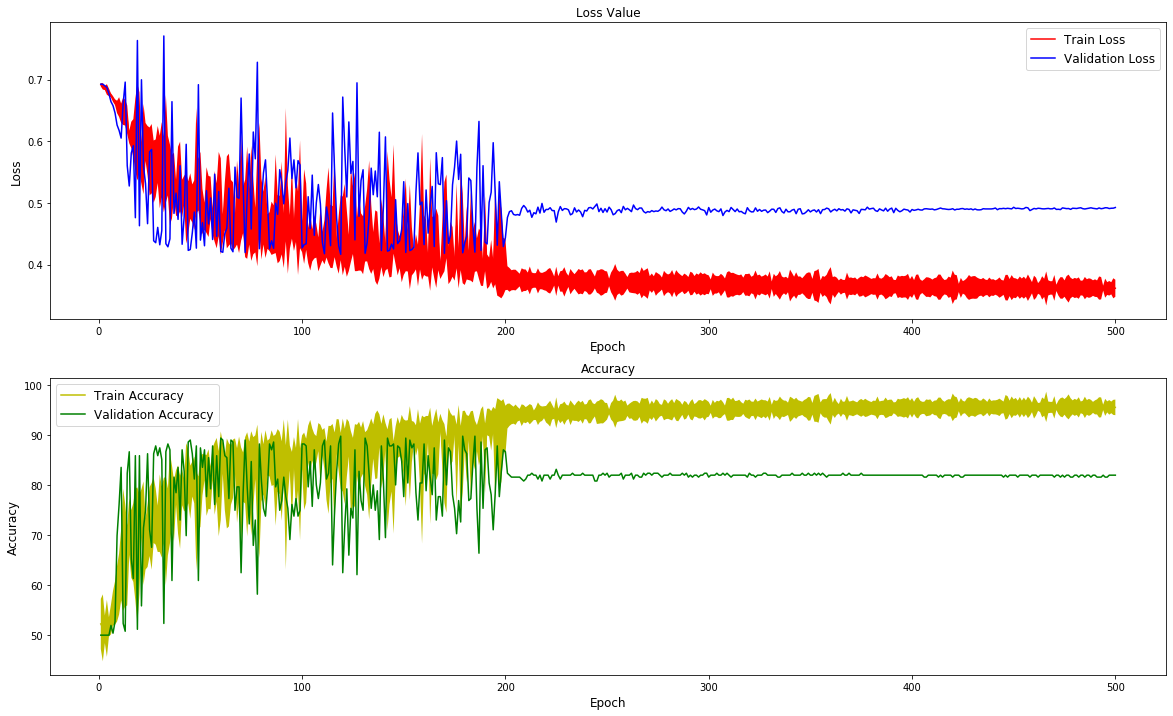

In [11]:
# PLOT TRAIN AND VALIDATION LOSS AT EVERY ITERATION
import matplotlib.pyplot as plt
import numpy as np

loss_std = np.array(loss_train_std)
acc_std = np.array(accuracy_train_std)
train_loss = np.array(loss_train_mean)
train_accuracy = np.array(accuracy_train)

fig, ax2 = plt.subplots(2,1,figsize=(20,12))
ax2[0].set_title("Loss Value")
ax2[0].set_ylabel("Loss", fontsize="12")
ax2[0].set_xlabel("Epoch", fontsize="12")
ax2[0].plot(range(1, len(train_loss)+1), train_loss,'-r', label='Train Loss')
ax2[0].plot(range(1, len(loss_test)+1), loss_test, '-b', label='Validation Loss')
ax2[0].fill_between(range(1, len(train_loss)+1), train_loss+loss_std, train_loss-loss_std, facecolor='red')
ax2[0].legend(fontsize="12")

# PLOT TRAIN AND VALIDATION ACCURACY AT EVERY ITERATION
ax2[1].set_title("Accuracy")
ax2[1].set_ylabel("Accuracy", fontsize="12")
ax2[1].set_xlabel("Epoch", fontsize="12")
ax2[1].plot(range(1, len(train_accuracy)+1), train_accuracy, '-y', label='Train Accuracy')
ax2[1].plot(range(1, len(accuracy_test)+1), accuracy_test, '-g', label='Validation Accuracy')
ax2[1].fill_between(range(1, len(train_accuracy)+1), train_accuracy+acc_std, train_accuracy-acc_std, facecolor='y')
ax2[1].legend(fontsize="12")
plt.show()

| dataset | loss | accuracy |
| :-- | -- | -- |
| train | {{ loss_train_mean[-1] }} | {{ accuracy_train[-1] }} |
| validation | {{ loss_test[-1] }} | {{ accuracy_test[-1] }} |